<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/FarmacoII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.0 MB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from pandas_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer



In [ ]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def addColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[col] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(f'{col}{self.postfix}')
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.addColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[col] = copia[col]
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], len(self.col_number_with_nan)))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)

      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

Leitura dos Dados


In [ ]:
SEED = 1234
np.random.seed(SEED)
warnings.filterwarnings(action='once')

dataFrame = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df = dataFrame.copy()
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23.0,F,HIGH,HIGH,25.355,MEDA
1,47.0,M,LOW,HIGH,13.093,MEDB
2,47.0,M,LOW,HIGH,10.114,MEDB
3,28.0,F,NORMAL,HIGH,7.798,MEDB
4,61.0,F,LOW,HIGH,18.043,MEDA


In [ ]:
print(df.columns)
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 
                  'NA_K', 'FARMACO']
df.sample(5)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')


,IDADE,SEXO,PA,COLESTEROL,NA_K,FARMACO
58,60.0,M,NORMAL,NORMAL,10.091,MEDB
6,49.0,F,NORMAL,HIGH,16.275,MEDA
31,74.0,M,HIGH,HIGH,9.567,MEDA
7,41.0,M,LOW,HIGH,11.037,MEDB
29,45.0,M,LOW,HIGH,17.951,MEDA


In [ ]:
df.shape

(225, 6)

In [ ]:
df.describe()

,IDADE,NA_K
count,223.000000,220.000000
mean,45.502242,16.186264
std,25.939443,7.731283
min,13.000000,3.870000
25%,30.500000,10.291750
50%,45.000000,13.952500
75%,58.000000,19.822000
max,333.000000,41.270000


In [ ]:
indice = df.query('IDADE == 333').index[0]
df.drop(axis='index', index=indice, inplace=True)

df.describe()


,IDADE,NA_K
count,222.000000,219.000000
mean,44.207207,16.187708
std,17.326577,7.748965
min,13.000000,3.870000
25%,30.250000,10.291500
50%,45.000000,13.938000
75%,58.000000,19.848000
max,98.000000,41.270000


In [ ]:
df.index = range(df.shape[0])

In [ ]:
ausentes = (1 - df.isna()).mean()
dfAusentes = pd.DataFrame(ausentes, columns=['pct'])
dfAusentes['feature'] = df.columns
dfAusentes.index = range(dfAusentes.shape[0])
dfAusentes

,pct,feature
0,0.991071,IDADE
1,1.000000,SEXO
2,0.959821,PA
3,0.973214,COLESTEROL
4,0.977679,NA_K
5,1.000000,FARMACO


In [ ]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Divisão dos Pacientes entre Med A / Med B')

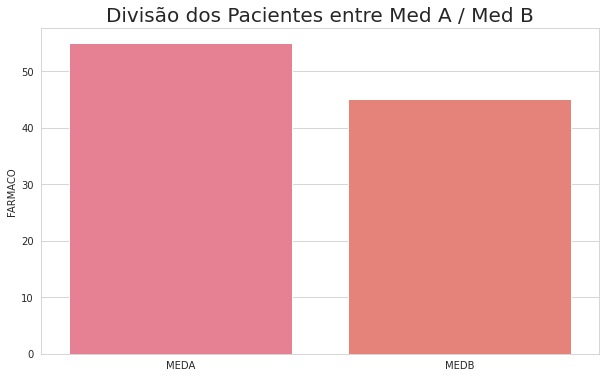

In [ ]:
sns.set_style("whitegrid")
ax = sns.barplot(x=df.FARMACO.unique(), y = df.FARMACO.value_counts(normalize=True) * 100, palette=sns.color_palette("husl", n_colors=30))
ax.figure.set_size_inches(10,6)
ax.set_title('Divisão dos Pacientes entre Med A / Med B', fontsize = 20)

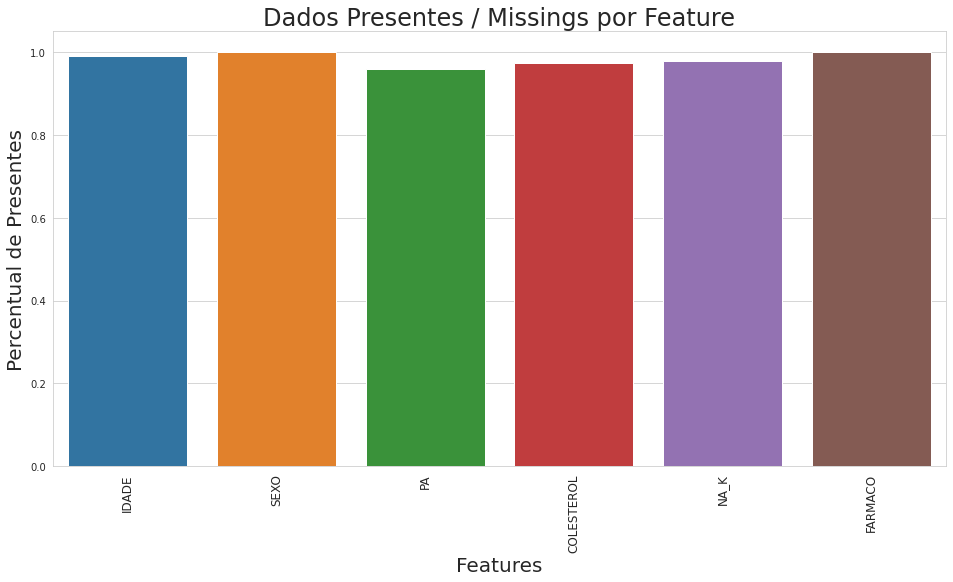

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.barplot(data=dfAusentes, x='feature', y='pct', ax=ax)
ax.set_title('Dados Presentes / Missings por Feature', fontsize = 24)
ax.set_ylabel('Percentual de Presentes', fontsize = 20)
ax.set_xlabel('Features', fontsize = 20)
ax.set_xticklabels(labels = dfAusentes.feature, rotation=90, fontsize = 12)
fig.show()

In [ ]:
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)

print(f'Treinaremos com {X_train.shape[0]} individuos e testaremos com {X_test.shape[0]} individuos')

Treinaremos com 156 individuos e testaremos com 68 individuos


In [ ]:
X_train.head()

,IDADE,SEXO,PA,COLESTEROL,NA_K
76,36.0,F,HIGH,HIGH,11.198
197,52.0,M,NORMAL,HIGH,9.894
135,74.0,M,LOW,NORMAL,11.939
181,59.0,F,NORMAL,HIGH,13.884
123,36.0,F,NORMAL,HIGH,16.753


Codificar o MEDA-MEDB como inteiro

In [ ]:
y_train

76     MEDB
197    MEDB
135    MEDB
181    MEDB
123    MEDA
       ... 
166    MEDA
157    MEDA
147    MEDB
215    MEDA
179    MEDA
Name: FARMACO, Length: 156, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = pd.Series(le.fit_transform(y_train))
y_train_le


0      1
1      1
2      1
3      1
4      0
      ..
151    0
152    0
153    1
154    0
155    0
Length: 156, dtype: int64

In [ ]:
X_train.tail(5)

,IDADE,SEXO,PA,COLESTEROL,NA_K
166,58.0,F,LOW,HIGH,26.645
157,53.0,M,LOW,HIGH,22.963
147,26.0,F,HIGH,NORMAL,12.307
215,NaN,F,LOW,NaN,17.230
179,67.0,F,NORMAL,HIGH,15.891


In [ ]:
oe = OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], ['LOW', 'NORMAL', 'HIGH']], handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train_oe = X_train.copy()
X_train_oe[['PA', 'COLESTEROL']] = oe.fit_transform(X_train_oe[['PA', 'COLESTEROL']])
X_train_oe.tail(5)

,IDADE,SEXO,PA,COLESTEROL,NA_K
166,58.0,F,0.0,2.0,26.645
157,53.0,M,0.0,2.0,22.963
147,26.0,F,2.0,1.0,12.307
215,NaN,F,0.0,NaN,17.230
179,67.0,F,1.0,2.0,15.891


In [ ]:
ohe = OneHotEncoder(drop='if_binary', sparse=False)
X_train_ohe = X_train_oe.copy()
X_train_ohe[['MASC_FEM']] = ohe.fit_transform(X_train_ohe[['SEXO']])
X_train_ohe.drop(['SEXO'], axis='columns', inplace=True)
X_train_ohe.tail(5)

,IDADE,PA,COLESTEROL,NA_K,MASC_FEM
166,58.0,0.0,2.0,26.645,0.0
157,53.0,0.0,2.0,22.963,1.0
147,26.0,2.0,1.0,12.307,0.0
215,NaN,0.0,NaN,17.230,0.0
179,67.0,1.0,2.0,15.891,0.0


In [ ]:
ss = StandardScaler()
X_train_ss = X_train_ohe.copy()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train_ss))
X_train_ss.columns = X_train_ohe.columns
X_train_ss.index = X_train_ohe.index
X_train_ss.tail(5)

,IDADE,PA,COLESTEROL,NA_K,MASC_FEM
166,0.751441,-1.269685,0.949922,1.289331,-0.987261
157,0.469055,-1.269685,0.949922,0.827233,1.012904
147,-1.055832,1.067158,-0.832648,-0.510114,-0.987261
215,NaN,-1.269685,NaN,0.107731,-0.987261
179,1.259737,-0.101263,0.949922,-0.060316,-0.987261


In [ ]:
def buscar_colunas_nan(data : pd.DataFrame) :
  col_name = []
  for col in data.columns :
    if(data[col].isna().sum() > 0) :
      col_name.append(col)
  return col_name

def marcar_campos_imputados(data : pd.DataFrame, colunas_nan = None) :
  data_modified = data.copy()
  for coluna_nan in colunas_nan :
    data_modified[f'{coluna_nan}_IMPUTED'] = data[coluna_nan].isna().astype(int)
  return data_modified

def buscar_colunas_nan_nome(data : pd.DataFrame) :
  col_name = buscar_colunas_nan(data)
  col_nan_nome = []
  for coluna_nan in col_name :
    col_nan_nome.append(f'{coluna_nan}_IMPUTED')
  return col_nan_nome  

def imputar_valores_treino(data : pd.DataFrame):
  columns_original = data.columns
  colunas_nan = buscar_colunas_nan(data)
  data_modified = marcar_campos_imputados(data, colunas_nan)
  imputer = KNNImputer(n_neighbors=5)
  imputed_data = imputer.fit_transform(data)
  df_imputed_data = pd.DataFrame(imputed_data, columns = columns_original)
  df_imputed_data.index = data.index
  for coluna_nan in colunas_nan :
    df_imputed_data[f'{coluna_nan}_IMPUTED'] = data_modified[f'{coluna_nan}_IMPUTED']
  return imputer, colunas_nan, df_imputed_data

def imputar_valores_teste(data : pd.DataFrame, imputer : _BaseImputer, colunas_nan : list):
  columns_original = data.columns
  data_modified = marcar_campos_imputados(data, colunas_nan)
  imputed_data = imputer.transform(data)
  df_imputed_data = pd.DataFrame(imputed_data, columns = columns_original)
  df_imputed_data.index = data.index
  for coluna_nan in colunas_nan :
    df_imputed_data[f'{coluna_nan}_IMPUTED'] = data_modified[f'{coluna_nan}_IMPUTED']
  return df_imputed_data  

In [ ]:
imputer, colunas_nan, X_train_imputed =  imputar_valores_treino(X_train_ss)
X_train_imputed.tail(5)

,IDADE,PA,COLESTEROL,NA_K,MASC_FEM,IDADE_IMPUTED,PA_IMPUTED,COLESTEROL_IMPUTED,NA_K_IMPUTED
166,0.751441,-1.269685,0.949922,1.289331,-0.987261,0,0,0,0
157,0.469055,-1.269685,0.949922,0.827233,1.012904,0,0,0,0
147,-1.055832,1.067158,-0.832648,-0.510114,-0.987261,0,0,0,0
215,-0.615309,-1.269685,0.593408,0.107731,-0.987261,1,0,1,0
179,1.259737,-0.101263,0.949922,-0.060316,-0.987261,0,0,0,0


In [ ]:
X_test_transformed = X_test.copy()
X_test_transformed[['PA', 'COLESTEROL']] = oe.transform(X_test[['PA', 'COLESTEROL']])
X_test_transformed[['MASC_FEM']] = ohe.transform(X_test_transformed[['SEXO']])
X_test_transformed.drop(['SEXO'], axis='columns', inplace=True)
X_test_ss = pd.DataFrame(ss.transform(X_test_transformed))
X_test_ss.columns = X_test_transformed.columns
X_test_ss.index = X_test_transformed.index
X_test_transformed = imputar_valores_teste(X_test_ss, imputer, colunas_nan)
y_test_transformed = pd.Series(le.transform(y_test))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classificador = DecisionTreeClassifier()
classificador.fit(X_train_imputed, y_train_le)
print(classificador)
print('Classificador com colunas de imputação e KnnImputer')
print(classificador.score(X_train_imputed, y_train_le))
print(classificador.score(X_test_transformed, y_test_transformed))

DecisionTreeClassifier()
Classificador com colunas de imputação e KnnImputer
1.0
1.0


In [ ]:
from sklearn.impute import SimpleImputer
X_train_nan = X_train_ss.copy()
simple_imputer = SimpleImputer(strategy='mean')
X_train_simple = pd.DataFrame(simple_imputer.fit_transform(X_train_nan))
X_train_simple.index = X_train_ss.index
X_train_simple.columns = X_train_ss.columns
X_train_simple.tail(5)

,IDADE,PA,COLESTEROL,NA_K,MASC_FEM
166,7.514412e-01,-1.269685,9.499220e-01,1.289331,-0.987261
157,4.690548e-01,-1.269685,9.499220e-01,0.827233,1.012904
147,-1.055832e+00,1.067158,-8.326477e-01,-0.510114,-0.987261
215,-1.874403e-16,-1.269685,8.764919e-17,0.107731,-0.987261
179,1.259737e+00,-0.101263,9.499220e-01,-0.060316,-0.987261


In [ ]:
X_test_transformed = X_test.copy()
X_test_transformed[['PA', 'COLESTEROL']] = oe.transform(X_test[['PA', 'COLESTEROL']])
X_test_transformed[['MASC_FEM']] = ohe.transform(X_test_transformed[['SEXO']])
X_test_transformed.drop(['SEXO'], axis='columns', inplace=True)
X_test_ss = pd.DataFrame(ss.transform(X_test_transformed))
X_test_ss.columns = X_test_transformed.columns
X_test_ss.index = X_test_transformed.index
X_test_simple =  pd.DataFrame(simple_imputer.transform(X_test_ss))
X_test_simple.index = X_test_ss.index
X_test_simple.columns = X_test_ss.columns
y_test_transformed = pd.Series(le.transform(y_test))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
classificador = DecisionTreeClassifier()
classificador.fit(X_train_simple, y_train_le)
print(classificador)
print('Classificador sem colunas de imputação e SimpleImputer')
print(classificador.score(X_train_simple, y_train_le))
print(classificador.score(X_test_simple, y_test_transformed))



DecisionTreeClassifier()
Classificador sem colunas de imputação e SimpleImputer
1.0
0.9852941176470589


In [ ]:
X_train_iwmm = X_train_ss.copy()
imputermissing = ImputerWithMissingMark(imputer = SimpleImputer(strategy='median'), postfix='_MISSING')
X_train_iwmm = imputermissing.fit_transform(X_train_iwmm)
X_train_iwmm.tail(5)


,IDADE,PA,COLESTEROL,NA_K,MASC_FEM,IDADE_MISSING,PA_MISSING,COLESTEROL_MISSING,NA_K_MISSING
166,0.751441,-1.269685,0.949922,1.289331,-0.987261,0,0,0,0
157,0.469055,-1.269685,0.949922,0.827233,1.012904,0,0,0,0
147,-1.055832,1.067158,-0.832648,-0.510114,-0.987261,0,0,0,0
215,0.101952,-1.269685,0.058637,0.107731,-0.987261,1,0,1,0
179,1.259737,-0.101263,0.949922,-0.060316,-0.987261,0,0,0,0


In [ ]:
X_test_transformed = X_test.copy()
X_test_transformed[['PA', 'COLESTEROL']] = oe.transform(X_test[['PA', 'COLESTEROL']])
X_test_transformed[['MASC_FEM']] = ohe.transform(X_test_transformed[['SEXO']])
X_test_transformed.drop(['SEXO'], axis='columns', inplace=True)
X_train_ss = pd.DataFrame(ss.transform(X_test_transformed))
X_train_ss.columns = X_test_transformed.columns
X_train_ss.index = X_test_transformed.index
X_test_transformed = imputermissing.transform(X_train_ss)
X_test_transformed.head()
y_test_transformed = pd.Series(le.transform(y_test))



KeyError: ignored

In [ ]:
def report_score(model, X_train, X_test, y_train, y_test) :
 score = model.fit(X_train, y_train).score(X_test, y_test)
 print(f'Modelo [{model.__class__.__name__}]: {np.round(score*100, 2)}%')


In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

report_score(DecisionTreeClassifier(random_state=SEED), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(SVC(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(MLPClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(GradientBoostingClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)
report_score(RandomForestClassifier(), X_train_iwmm, X_test_transformed, y_train, y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                        ('imputer', ImputerWithMissingMark(imputer = SimpleImputer(strategy='median'))), ('classificador', DecisionTreeClassifier(random_state=SEED))])

model.fit(X_train, y_train)

print(f'{np.round(model.score(X_train, y_train)*100, 2)}%')
print(f'{np.round(model.score(X_test, y_test)*100, 2)}%')




In [ ]:
from sklearn import set_config
set_config(display="diagram")
model


In [ ]:
from sklearn.dummy import DummyClassifier
baseline_model = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                        ('imputer', ImputerWithMissingMark(imputer = SimpleImputer(strategy='median'))), ('classificador', DummyClassifier(strategy='stratified'))])

baseline_model.fit(X_train, y_train)

print(f'{np.round(baseline_model.score(X_train, y_train)*100, 2)}%')
print(f'{np.round(baseline_model.score(X_test, y_test)*100, 2)}%')



In [ ]:
np.random.seed(seed=None)
for i in range(10) :
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
  model.fit(X_train, y_train)
  print(f'{np.round(model.score(X_test, y_test)*100, 2)}%')


